# Information geometry

Lead author: Alice Le Brigant.

Disclaimer: this notebook requires the use of the ```numpy``` backend.

## Introduction

Information geometry is a branch of mathematics at the crossroads of statistics and differential geometry, focused on the study of probability distributions from a geometric point of view. One of the tools of information geometry is the Fisher information distance, which allows to compare probability distributions inside a given parametric family. In that sense, information geometry is an alternative approach to optimal transport. 

The Fisher information metric or Fisher-Rao metric - although the latter usually denotes its non parametric counterpart - is a Riemannian metric defined on the space of parameters of a family of distributions using the Fisher information matrix. This metric is invariant under change of parameterization. Moreover it is the only Riemannian metric compatible with the notion of information contained by the model on the parameter, in the sense that it is the only metric that preserves the geometry of a parametric model after transformation by a sufficient statistic (Cencov's theorem). For an overview, see [[A2016]](#References).

In [1]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import geomstats.backend as gs
import geomstats.visualization as visualization

INFO: Using numpy backend


## Normal distributions

The Fisher information geometry of the family of normal distributions is arguably the most well-known. The space of parameters is the upper half-plane where the x-coordinate encodes the mean and the y-coordinate the standard deviation. Quite remarkably, the Fisher information metric induces the hyperbolic geometry of the Poincare half plane [[AM1981]](#References). To start, we need an instance of the class ```NormalDistributions``` and its Fisher information metric.

In [2]:
from geomstats.information_geometry.normal import NormalDistributions

normal = NormalDistributions(sample_dim=1)

Using the ```visualization``` module, we can plot the geodesic between two points, each defining the parameters (mean and standard deviation) for a normal distribution. We recognise the shape of a geodesic of the Poincare half-plane, namely a half-circle orthogonal to the x-axis.

In [3]:
point_a = gs.array([1.0, 1.0])
point_b = gs.array([3.0, 1.0])

geodesic_ab_fisher = normal.metric.geodesic(point_a, point_b)

n_points = 20
t = gs.linspace(0, 1, n_points)

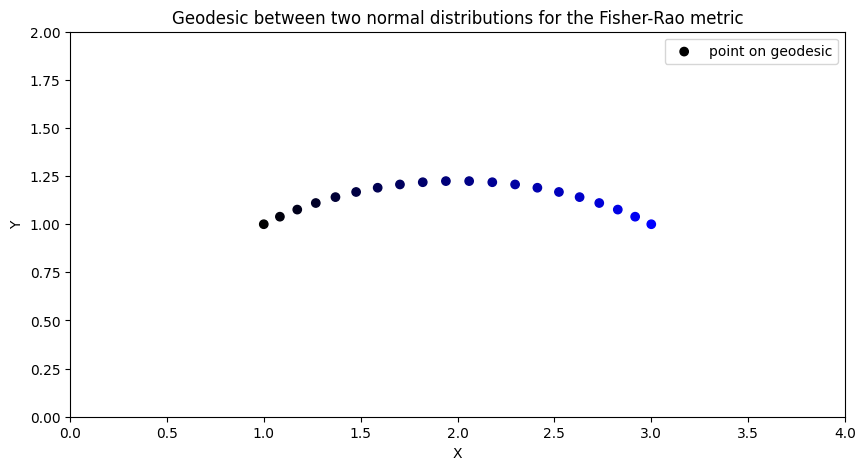

In [4]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
cc = gs.zeros((n_points, 3))
cc[:, 2] = gs.linspace(0, 1, n_points)

visualization.plot(
    geodesic_ab_fisher(t),
    ax=ax,
    space="H2_poincare_half_plane",
    label="point on geodesic",
    color=cc,
)

ax.set_xlim(0.0, 4.0)
ax.set_ylim(0.0, 2.0)
ax.set_title("Geodesic between two normal distributions for the Fisher-Rao metric")
ax.legend();

Each point of the geodesic defines a normal distribution, and so we obtain an optimal interpolation between the distributions corresponding to ```point_a``` and ```point_b```, which we can visualize in terms of probability density functions.

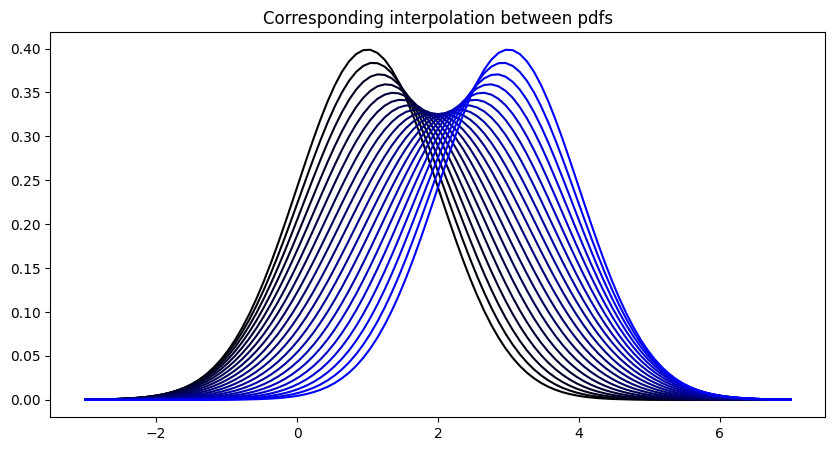

In [5]:
pdfs = normal.point_to_pdf(geodesic_ab_fisher(t))
x = gs.linspace(-3.0, 7.0, 100)

fig = plt.figure(figsize=(10, 5))
for i in range(n_points):
    plt.plot(x, pdfs(x)[i, :], color=cc[i, :])
plt.title("Corresponding interpolation between pdfs");

Another possibility to compare probability distributions is given by the $L^2$-Wasserstein metric, central in optimal transport. In the case of normal distributions, the $L^2$-Wasserstein metric induces the Euclidean geometry on the upper half plane [[BGKL2017]](#References). Therefore, the Wasserstein distance between two normal distributions with different means and same variance (```point_a``` and ```point_b```) will not change when this common variance is increased (```point_c``` and ```point_d```), while the corresponding Fisher information distance will decrease, as can be deduced from the shape of the geodesic. This can be interpreted as a consequence of the increasing overlap of the corresponding probability densities.

In [6]:
from geomstats.geometry.euclidean import Euclidean

plane = Euclidean(2)

point_c = gs.array([1.0, 3.0])
point_d = gs.array([3.0, 3.0])

geodesic_cd_fisher = normal.metric.geodesic(point_c, point_d)
geodesic_ab_wasserstein = plane.metric.geodesic(point_a, point_b)
geodesic_cd_wasserstein = plane.metric.geodesic(point_c, point_d)

points = gs.stack((point_a, point_b, point_c, point_d))
pdfs = normal.point_to_pdf(points)

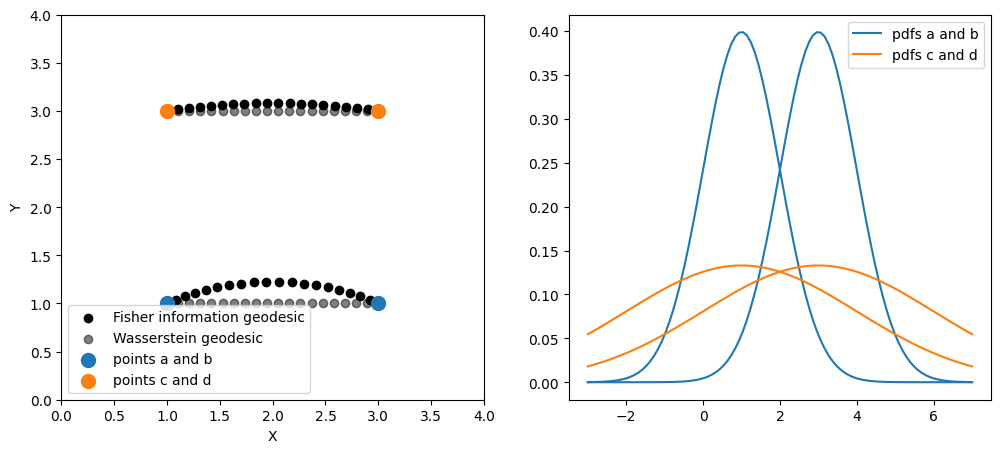

In [7]:
%matplotlib inline

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)

visualization.plot(
    gs.vstack((geodesic_ab_fisher(t), geodesic_cd_fisher(t))),
    ax=ax1,
    space="H2_poincare_half_plane",
    label="Fisher information geodesic",
    color="black",
)
visualization.plot(
    gs.vstack((geodesic_ab_wasserstein(t), geodesic_cd_wasserstein(t))),
    ax=ax1,
    space="H2_poincare_half_plane",
    label="Wasserstein geodesic",
    color="black",
    alpha=0.5,
)
visualization.plot(
    gs.stack((point_a, point_b)),
    ax=ax1,
    space="H2_poincare_half_plane",
    label="points a and b",
    s=100,
)
visualization.plot(
    gs.stack((point_c, point_d)),
    ax=ax1,
    space="H2_poincare_half_plane",
    label="points c and d",
    s=100,
)

ax1.set_xlim(0.0, 4.0)
ax1.set_ylim(0.0, 4.0)
ax1.legend()

ax2 = fig.add_subplot(122)
x = gs.linspace(-3.0, 7.0, 100)
lines = [Line2D([0], [0], color="C0"), Line2D([0], [0], color="C1")]
ax2.plot(x, pdfs(x)[:2, :].T, c="C0")
ax2.plot(x, pdfs(x)[2:, :].T, c="C1")
ax2.legend(lines, ["pdfs a and b", "pdfs c and d"]);

## Beta distributions

Let us now consider the example of beta distributions, where the space of parameters is the first quadrant. In this case, the geodesics for the Fisher-Rao metric do not have a closed form, but can be found numerically [[LGRP2020]](#References). Here we plot an example of geodesic ball.

In [8]:
from geomstats.information_geometry.beta import BetaDistributions

beta = BetaDistributions()

In [9]:
beta.shape

(2,)

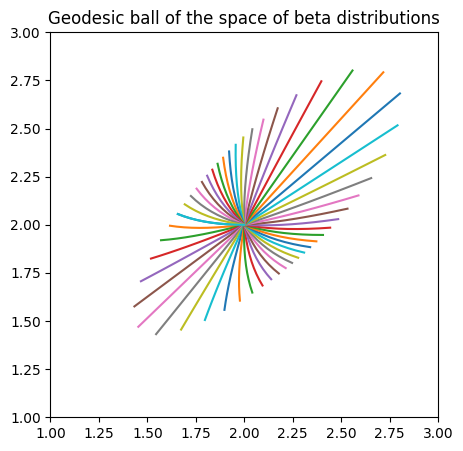

In [10]:
n_rays = 50
center = gs.array([2.0, 2.0])
theta = gs.linspace(-gs.pi, gs.pi, n_rays)
directions = gs.transpose(gs.stack((gs.cos(theta), gs.sin(theta))))

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ray_length = 0.25
direction_norms = beta.metric.squared_norm(directions, center) ** (1 / 2)
unit_vectors = directions / gs.expand_dims(direction_norms, 1)
initial_vectors = ray_length * unit_vectors

n_points = 10
t = gs.linspace(0.0, 1.0, n_points)
for j in range(n_rays):
    geod = beta.metric.geodesic(
        initial_point=center, initial_tangent_vec=initial_vectors[j, :]
    )
    ax.plot(*gs.transpose(geod(t)))
ax.set_xlim(1, 3)
ax.set_ylim(1, 3)
ax.set_title("Geodesic ball of the space of beta distributions");

Now we consider an application to the study of the leaf inclination angle distribution of plants. The leaf angle distribution among a common plant species can be appropriately represented by a beta distribution ([CPR2018](#References)). The dataset `leaves` ([CPR2018](#References)) contains pairs of beta distribution parameters, each describing the distribution of the inclination angles of leaves inside a given plant species. These species are divided into 5 categories according to inclination angle distribution type: spherical, erectophile, uniform, planophile and plagiophile.

In [11]:
import geomstats.datasets.utils as data_utils

beta_param, distrib_type = data_utils.load_leaves()

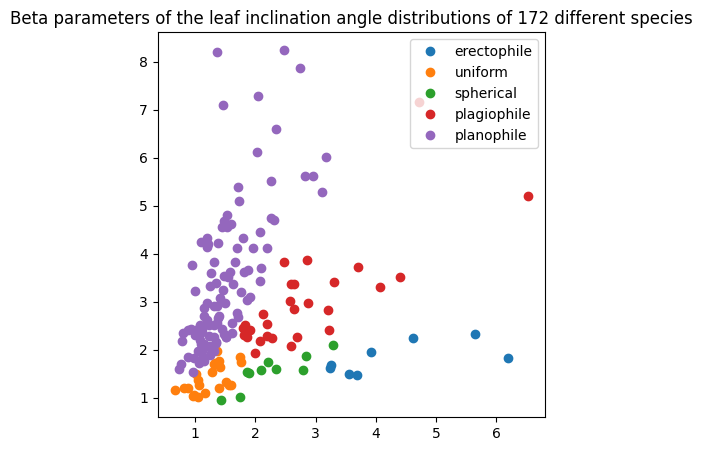

In [12]:
fig = plt.figure(figsize=(5, 5))
for distrib in set(distrib_type):
    points = beta_param[distrib_type == distrib, :]
    plt.plot(points[:, 0], points[:, 1], "o", label=distrib)
plt.title(
    "Beta parameters of the leaf inclination angle distributions of 172 different species"
)
plt.legend();

Using the ```FrechetMean``` learning class, we can compute the leaf inclination angle mean distribution among the species of type 'planophile'.

In [13]:
from geomstats.learning.frechet_mean import FrechetMean

points_plan = beta_param[distrib_type == "planophile", :]

mean = FrechetMean(beta)
mean.fit(points_plan)

mean_estimate = mean.estimate_

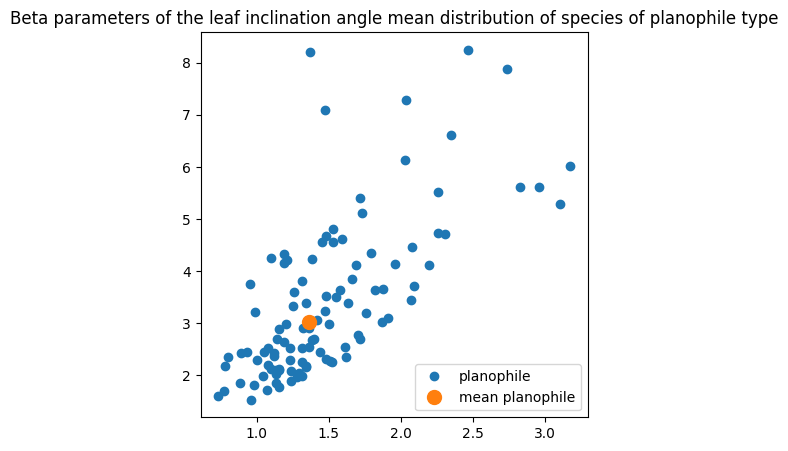

In [14]:
fig = plt.figure(figsize=(5, 5))
plt.plot(points_plan[:, 0], points_plan[:, 1], "o", label="planophile")
plt.plot(*mean_estimate, "o", markersize=10, label="mean planophile")
plt.title(
    "Beta parameters of the leaf inclination angle mean distribution "
    "of species of planophile type"
)
plt.legend();

## References

.. [A2016] S. Amari. Information geometry and its applications. Vol. 194. Springer, 2016.

.. [AM1981] C. Atkinson and A. FS Mitchell. Rao’s distance measure. Sankhya: The Indian Journal of Statistics. Series A, pp. 345–365, 1981.

.. [BGKL2017] J. Bigot, R. Gouet, T. Klein and A. López. Geodesic PCA in the Wasserstein space by convex PCA. In Annales de l'Institut Henri Poincaré, Probabilités et Statistiques. Vol. 53. No. 1. Institut Henri Poincaré, 2017.

.. [CPR2018] F. Chianucci, J. Pisek, K. Raabe et al. A dataset of leaf inclination angles for temperate and boreal broadleaf woody species. Annals of Forest Science Vol. 75, No. 50, 2018. https://doi.org/10.17632/4rmc7r8zvy.2.

.. [LGRP2020] A. Le Brigant, N. Guigui, S. Rebbah and S. Puechmorel, Classifying histograms of medical data using information geometry of beta distributions. IFAC-PapersOnLine, Vol. 54, No. 9, 514-520, 2021.